In [12]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt

FILES_WEEKDAY = {
    'non_cbd_24': 'NonCBD_2024_Thu.csv',
    'cbd_24':     'CBD_2024_Thu.csv',
    'non_cbd_25': 'NonCBD_2025_Thu.csv',
    'cbd_25':     'CBD_2025_Thu.csv'
}

FILES_WEEKEND = {
    'non_cbd_24': 'NonCBD_2024_Sat.csv',
    'cbd_24':     'CBD_2024_Sat.csv',
    'non_cbd_25': 'NonCBD_2025_Sat.csv',
    'cbd_25':     'CBD_2025_Sat.csv'
}

DATASETS = [
    ('non_cbd_24', False, False),
    ('cbd_24', True, False),
    ('non_cbd_25', False, True),
    ('cbd_25', True, True),
]


def load_and_prep_exclusive(file_path, is_treated, is_post, target_hours):
    """Aggregate trips after excluding origins inside the destination region."""
    df = pd.read_csv('data/' + file_path)

    df['end_dt'] = pd.to_datetime(df['trip_end_time'], format='%H:%M:%S', errors='coerce')
    df['hour'] = df['end_dt'].dt.hour
    df = df[df['hour'].isin(target_hours)]

    df = df[df['origin_trct_2020'] != 'Out of Region']
    df = df[df['destination_trct_2020'] != 'Out of Region']

    df['origin_bgrp_2020'] = df['origin_bgrp_2020'].fillna('').astype(str).str.strip()
    df = df[df['origin_bgrp_2020'] != 'Out of Region']
    dest_values = (
        df['destination_bgrp_2020']
        .fillna('')
        .astype(str)
        .str.strip()
    )
    dest_set = {val for val in dest_values if val and val.lower() != 'nan' and val != 'Out of Region'}
    df = df[~df['origin_bgrp_2020'].isin(dest_set)]

    df['od_id'] = df['origin_trct_2020'].astype(str) + '_' + df['destination_trct_2020'].astype(str)

    df_agg = df.groupby('od_id').size().reset_index(name='volume')
    df_agg['treated'] = 1 if is_treated else 0
    df_agg['post'] = 1 if is_post else 0
    df_agg['year'] = 2025 if is_post else 2024
    return df_agg


In [13]:
def estimate_hourly_effects(label, file_mapping, significance=0.05, hours=range(24)):
    """Estimate DID log-volume treatment effects separately for each hour."""
    results = []
    for hour in hours:
        frames = [
            load_and_prep_exclusive(file_mapping[key], treated, post, [hour])
            for key, treated, post in DATASETS
        ]
        df_raw = pd.concat(frames, ignore_index=True)
        if df_raw.empty:
            continue
        all_ods = df_raw[['od_id', 'treated']].drop_duplicates()
        years = pd.DataFrame({'year': [2024, 2025], 'post': [0, 1]})
        df_balanced = all_ods.merge(years, how='cross')
        df_final = df_balanced.merge(df_raw[['od_id', 'year', 'volume']], on=['od_id', 'year'], how='left')
        df_final['volume'] = df_final['volume'].fillna(0)
        df_final['did'] = df_final['treated'] * df_final['post']
        df_final['log_volume'] = np.log1p(df_final['volume'])

        df_fe = df_final.set_index(['od_id', 'year'])

        model = PanelOLS.from_formula('log_volume ~ post + did + EntityEffects', data=df_fe)
        res = model.fit()

        coef_did = res.params['did']
        p_value = res.pvalues['did']
        pct_change = (np.exp(coef_did) - 1) * 100
        ci_low, ci_high = res.conf_int().loc['did']
        ci_lower_pct = (np.exp(ci_low) - 1) * 100
        ci_upper_pct = (np.exp(ci_high) - 1) * 100

        post_coef = res.params['post']
        post_p_value = res.pvalues['post']

        results.append({
            'hour': hour,
            'coef_did': coef_did,
            'p_value': p_value,
            'pct_change': pct_change,
            'ci_lower': ci_low,
            'ci_upper': ci_high,
            'ci_lower_pct': ci_lower_pct,
            'ci_upper_pct': ci_upper_pct,
            'significant': p_value < significance,
            'post_coef': post_coef,
            'post_p_value': post_p_value
        })

    result_df = pd.DataFrame(results)
    print(f"=== {label} Hourly Treatment Effects ===")
    if result_df.empty:
        print('No data available for any hour after filtering.')
    else:
        print(result_df)
    return result_df


# Run the experiments
Takes about 5 minutes on 2020 M1 MacBook Pro

In [14]:
weekday_hourly_effects = estimate_hourly_effects(
    'Weekday Outside-Zone',
    FILES_WEEKDAY,
    significance=0.05,
    hours=range(24),
)

weekend_hourly_effects = estimate_hourly_effects(
    'Weekend Outside-Zone',
    FILES_WEEKEND,
    significance=0.1,
    hours=range(24),
)

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/' + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/' + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/' + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/' + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26)

=== Weekday Outside-Zone Hourly Treatment Effects ===
    hour  coef_did       p_value  pct_change  ci_lower  ci_upper  \
0      0  0.124662  1.420991e-02   13.276530  0.025079  0.224244   
1      1  0.164471  3.622321e-02   17.876885  0.010620  0.318321   
2      2  0.113140  2.097784e-01   11.978828 -0.064068  0.290347   
3      3  0.281527  7.519960e-10   32.515190  0.192601  0.370453   
4      4  0.004839  8.837178e-01    0.485028 -0.060028  0.069705   
5      5 -0.101910  6.645093e-06   -9.688957 -0.146225 -0.057596   
6      6 -0.166549  0.000000e+00  -15.341902 -0.201528 -0.131571   
7      7 -0.103711  3.830378e-10   -9.851401 -0.136162 -0.071260   
8      8 -0.111455  8.770762e-14  -10.546821 -0.140725 -0.082185   
9      9 -0.123650  0.000000e+00  -11.631054 -0.150636 -0.096663   
10    10 -0.076352  5.774864e-09   -7.350954 -0.102039 -0.050664   
11    11 -0.055162  1.653935e-05   -5.366858 -0.080258 -0.030067   
12    12 -0.036997  4.095556e-03   -3.632108 -0.062255 -0.0117

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/' + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/' + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/' + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/' + file_path)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/865055889.py:30: DtypeWarning: Columns (26)

=== Weekend Outside-Zone Hourly Treatment Effects ===
    hour  coef_did   p_value  pct_change  ci_lower  ci_upper  ci_lower_pct  \
0      0  0.008636  0.898493    0.867357 -0.124318  0.141590    -11.690097   
1      1  0.035796  0.719400    3.644464 -0.160399  0.231992    -14.819624   
2      2  0.012653  0.919446    1.273295 -0.234427  0.259732    -20.897606   
3      3  0.121264  0.032179   12.892273  0.010343  0.232185      1.039682   
4      4  0.025936  0.543512    2.627549 -0.057794  0.109666     -5.615564   
5      5 -0.021734  0.477128   -2.149983 -0.081670  0.038202     -7.842430   
6      6  0.018883  0.362384    1.906289 -0.021755  0.059522     -2.151971   
7      7 -0.013238  0.437009   -1.315103 -0.046623  0.020146     -4.555253   
8      8 -0.049030  0.001295   -4.784730 -0.078897 -0.019163     -7.586445   
9      9 -0.029665  0.041079   -2.922932 -0.058128 -0.001202     -5.647071   
10    10 -0.006807  0.643037   -0.678418 -0.035598  0.021983     -3.497143   
11    11 -

In [15]:
weekday_hourly_effects.to_csv('results/micro/weekday_hourly_effects.csv', index=False)
weekend_hourly_effects.to_csv('results/micro/weekend_hourly_effects.csv', index=False)

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/2233222809.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_58262/2233222809.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


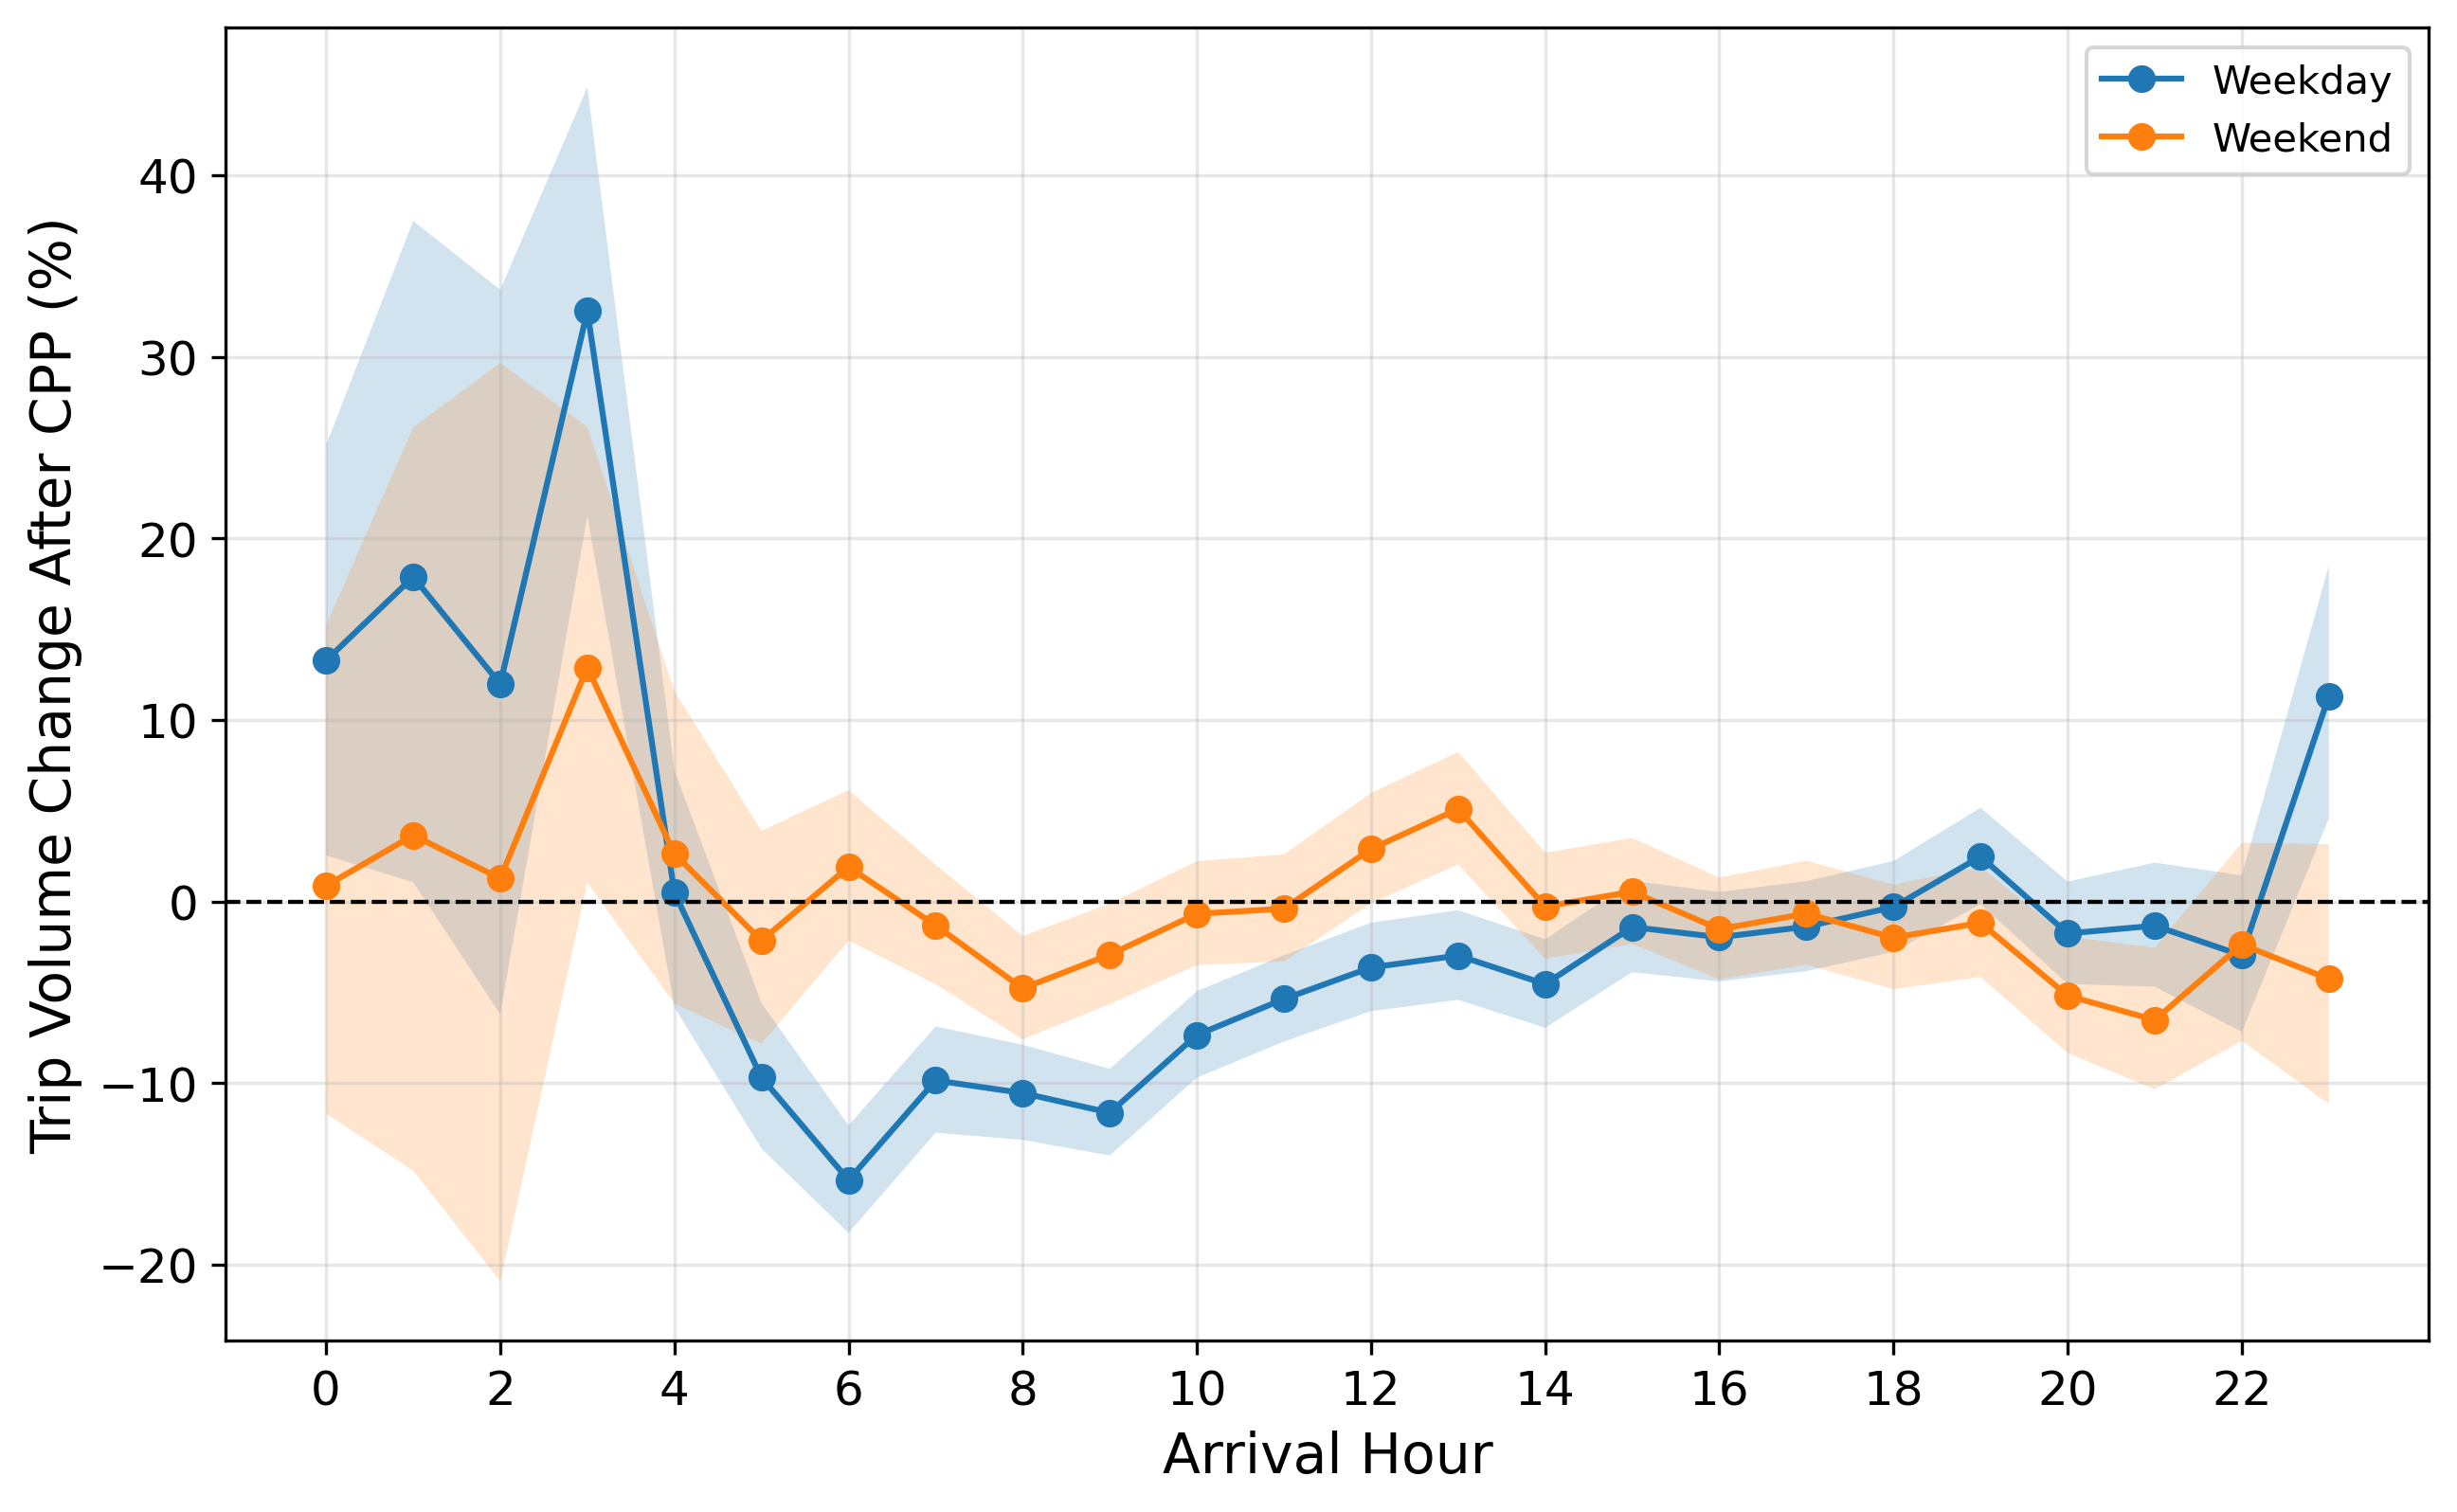

In [18]:
def plot_hourly_effects(hourly_effects, ax, color, label):
    x = hourly_effects['hour']
    y = hourly_effects['pct_change']
    ci_5 = hourly_effects['ci_lower_pct']
    ci_95 = hourly_effects['ci_upper_pct']
    p = ax.plot(x, y, marker='o', label=label, c=color)
    ax.fill_between(x, ci_5, ci_95, alpha=0.2, facecolor=color)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Arrival Hour', fontsize=14)
    ax.set_ylabel('Trip Volume Change After CPP (%)', fontsize=14)
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels(range(0, 24, 2), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend()
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
plot_hourly_effects(weekday_hourly_effects, ax, color='tab:blue', label='Weekday')
plot_hourly_effects(weekend_hourly_effects, ax, color='tab:orange', label='Weekend')
fig.savefig('figures/micro/hourly_treatment_effects.png', dpi=300)
plt.show()